In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
bus_adjacency: BUS_ANY
incarnation: 15285412221132643114
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 10635427840
incarnation: 9702838273114206262
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0"
]


In [2]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
import cv2

Using TensorFlow backend.


In [3]:
def make_parallel(model, gpu_count):
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat(0, [ shape[:1] // parts, shape[1:] ])
        stride = tf.concat(0,[ shape[:1] // parts, shape[1:]*0 ])
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                

                outputs = model(inputs)
                
                if not isinstance(outputs, list):
                    outputs = [outputs]
                
                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            #merged.append(Concatenate(axis=0)(outputs))
            merged.append(merge(outputs, mode='concat', concat_axis=0))
        return Model(model.inputs, merged)

In [4]:
make_parallel(model, 2)

NameError: name 'model' is not defined

In [3]:
train_path = 'data/baidu/image_contest_level_2_processed/'
label_exp_count = load_array('data/baidu/label_exp_num.data')

In [4]:
label_exp_files = []
for i, cnt in enumerate(label_exp_count):
    files = []
    for c in range(cnt):
        files.append('{}-{}-{}.png'.format(i, cnt-c, cnt))
    label_exp_files.append(files)

In [5]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
exp_labels = []
exp_lens =[]
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    exp_labels.append(exprs.decode('utf8'))
    label_exp_num_length.append(len(exprs.split(';')))
    exp_lens.append(len(exprs.decode('utf8')))

In [6]:
class DataGenator(keras.callbacks.Callback):
    
    def __init__(self, s_w, s_h, l_w, l_h):
        self.idxs = np.arange(100000)
        self.label_length = max(np.asarray(exp_lens)[self.idxs])
        
        self.s_w=s_w
        self.s_h=s_h
        self.l_w=l_w
        self.l_h=l_h

        mask = np.random.rand(len(self.idxs)) < 0.9
        self.trn_idxs = self.idxs[mask]
        self.val_idxs = self.idxs[~mask]
        
        self.token_counts = {}
        for exp in np.asarray(exp_labels):
            for c in exp:
                if c in self.token_counts:
                    self.token_counts[c] += 1
                else:
                    self.token_counts[c] = 1
        self.tokens = sorted(self.token_counts.keys()) + ['N']
        self.zero_idx = len(self.tokens)-1
        
        
        self.token_idxs = dict()
        for i,token in enumerate(self.tokens):
            self.token_idxs[token] = i
            
        #所有的label都转化  但不会全部用上  用不上的为空
        self.actual_labels = np.full((len(exp_labels), self.label_length), self.zero_idx)
        for idx in self.idxs:
            for i, token in enumerate(exp_labels[idx]):
                self.actual_labels[idx][i] = self.token_idxs[token]
            
    def get_batch(self, batch_size, idxs, shuffle=True):
        if shuffle:  
            idxs = np.random.permutation(idxs)
        cur = 0
        idxs_len = len(idxs)
        while True:
            out = []
            next_cur = cur + batch_size
            if next_cur < idxs_len:
                out = idxs[cur: next_cur]
                cur = next_cur
            else:
                exceed = next_cur - idxs_len
                out = idxs[cur: idxs_len]
                if shuffle:  idxs = np.random.permutation(idxs)
                out = np.concatenate([out, idxs[0: exceed]]) 
                cur = exceed
            
            imgs = self.fetch_img_by_idxs(out)
            
            yield imgs[0], imgs[1], imgs[2], np.asarray(self.actual_labels)[out]
        
    def fetch_img_by_idxs(self, idxs):
        size = len(idxs)
        left = np.zeros((size, self.s_w, self.s_h, 3))
        mid = np.zeros((size, self.s_w, self.s_h, 3))
        right = np.zeros((size, self.l_w, self.l_h, 3))
        for i, fs in enumerate(np.array(label_exp_files)[idxs]):
            
            if len(fs) == 2:
                left[i] = self.fetch_img(fs[0], self.s_w, self.s_h)
                right[i] = self.fetch_img(fs[1], self.l_w, self.l_h)
            if len(fs) == 3:
                left[i] = self.fetch_img(fs[0], self.s_w, self.s_h)
                mid[i] = self.fetch_img(fs[1], self.s_w, self.s_h)
                right[i] = self.fetch_img(fs[2], self.l_w, self.l_h)
            
        return [left, mid, right]
    
    def fetch_img(self, f, w, h):
        img = cv2.imread(train_path+f)
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img= np.expand_dims(img, axis=-1)
        img = np.transpose(np.asarray(img), (1, 0, 2))
        return img
    
    def to_pretty_label(self, label):
        l = label.flatten().astype('int')
        s =''
        for token in l:
            if token != self.zero_idx:
                 s = s+self.tokens[token]
        return s    

In [7]:
img_gen = DataGenator(s_w=120, s_h=60, l_w=400, l_h=60)


In [64]:
batches = img_gen.get_batch(64, img_gen.trn_idxs)
x1, x2, x3, x4 = next(batches)

In [66]:
x1.shape, x2.shape, x3.shape, x4.shape

((64, 120, 60, 3), (64, 120, 60, 3), (64, 400, 60, 3), (64, 41))

君=28602;板=21617;(板*君/81670+16984)-41910


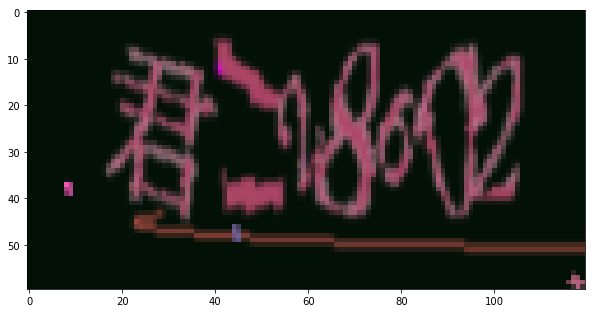

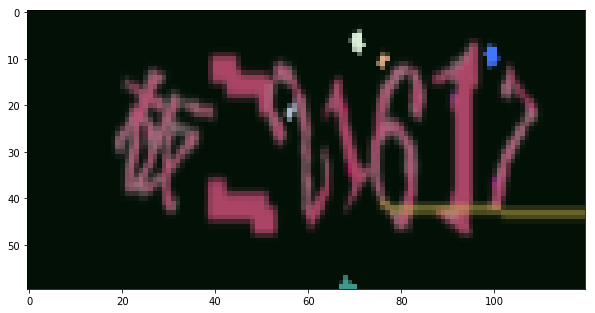

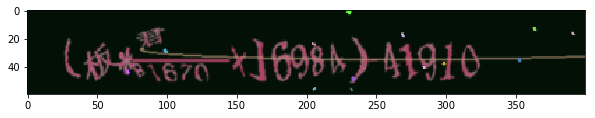

In [78]:
i = 1

f = plt.figure(figsize=(10,10))
plt.imshow(x1[i].transpose(1,0,-1))

f = plt.figure(figsize=(10,10), frameon=True)
plt.imshow(x2[i].transpose(1,0,-1))

f = plt.figure(figsize=(10,10), frameon=True)
plt.imshow(x3[i].transpose(1,0,-1))

print(img_gen.to_pretty_label(x4[i]))


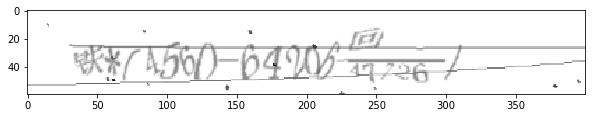

In [26]:
img_gen = DataGenator(s_w=120, s_h=60, l_w=400, l_h=60)



#f = plt.figure(figsize=(10,10), frameon=True)
#plt.imshow(test_imgs[3])

In [8]:
s_w=120 
s_h=60
l_w=400
l_h=60

img_gen = DataGenator(s_w=s_w, s_h=s_h, l_w=l_w, l_h=l_h)

In [8]:
def save_raw_data():
    da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
    imgs, labels = next(da)
    save_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix),  imgs)
    save_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix), labels)

def load_raw_data():
    imgs = load_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix))
    labels = load_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix))
    return (imgs, labels)
    
def save_split_data(x_trn, y_trn, x_val, y_val):

    save_array(data_path+"x_trn", x_trn)
    save_array(data_path+"y_trn", y_trn)


    save_array(data_path+"x_val", x_val)
    save_array(data_path+"y_val", y_val)

def load_split_data():

    x_trn = load_array(data_path+"x_trn")
    y_trn = load_array(data_path+"y_trn")

    x_val = load_array(data_path+"x_val")
    y_val = load_array(data_path+"y_val")
    
    return (x_trn, y_trn, x_val, y_val)

In [11]:
#save_raw_data()
imgs, labels = load_raw_data()

In [12]:
mask = np.random.rand(len(using_idxs)) < 0.9
idxs = np.random.permutation(len(using_idxs))
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]


#da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
#imgs, labels = next(da)

x_trn = imgs[trn_idxs]
y_trn = labels[trn_idxs]

x_val = imgs[val_idxs]
y_val = labels[val_idxs]

In [9]:
#save_split_data(x_trn, y_trn, x_val, y_val)
x_trn, y_trn, x_val, y_val = load_split_data()

In [10]:
x_trn.shape, y_trn.shape, x_val.shape, y_val.shape

((90059, 600, 90, 3), (90059, 30), (9941, 600, 90, 3), (9941, 30))

In [9]:
def show_data(x, y):  
    for i in range(len(x)):
        print(img_gen.to_pretty_label(y[i]))
        plots(np.expand_dims(x[i], axis=0))

In [10]:
def gen_label_length(labels):
    label_lengths = np.zeros((len(labels), 1))
    for i in range(len(labels)):
        label_lengths[i] = len(np.where(np.array(labels[i]) != img_gen.zero_idx)[0])
    return label_lengths.astype('uint8')

In [11]:
def map2seq(x):
    shape = K.shape(x)
    return K.reshape(x, (shape[0], shape[1], shape[3]))

In [12]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[1], shape[3])

In [14]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

 zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03

In [15]:
batch_size = 64
da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05,
                             channel_shift_range=20, rotation_range=5, 
                             height_shift_range=0.03, width_shift_range=0.03)
#da = image.ImageDataGenerator()
#x_trn_len = len(x_trn)//batch_size*batch_size
#trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)

In [16]:
def trn_gen():
    trn_batches = img_gen.get_batch(batch_size, img_gen.trn_idxs, shuffle=True)
    #减2是因为进入ctc时  已经丢弃了2帧
    input_length = np.zeros([batch_size, 1]) + 137
    while True:
        x1, x2, x3, y = next(trn_batches)
        x1_tf = np.zeros(x1.shape)
        x2_tf = np.zeros(x2.shape)
        x3_tf = np.zeros(x3.shape)
        for i, img in enumerate(x1):            
            x1_tf[i] = da.random_transform(img)
        for i, img in enumerate(x2):            
            x2_tf[i] = da.random_transform(img)
        for i, img in enumerate(x3):            
            x3_tf[i] = da.random_transform(img)
        label_length = gen_label_length(y)
        y[np.where(y==img_gen.zero_idx)] = 0
        yield [x1_tf, x2_tf, x3_tf, y, input_length, label_length], np.zeros([batch_size])

In [17]:
val_data_batches = img_gen.get_batch(len(img_gen.val_idxs), img_gen.val_idxs, shuffle=False)
x1_val, x2_val, x3_val, y_val = next(val_data_batches)
size = len(x1_val)
#减2是因为进入ctc时  已经丢弃了2帧
x_val_input_length = np.zeros([size, 1]) + 137
y_val_label_length = gen_label_length(y_val)
def val_data():
    return [x1_val,x2_val,x3_val, y_val, x_val_input_length, y_val_label_length], np.zeros([size])

In [61]:
batches = trn_gen()
def inspect_trn_data():
    batch = next(batches)[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)
def inspect_val_data():
    batch = val_data()[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)

(400, 60, 1)


TypeError: Invalid dimensions for image data

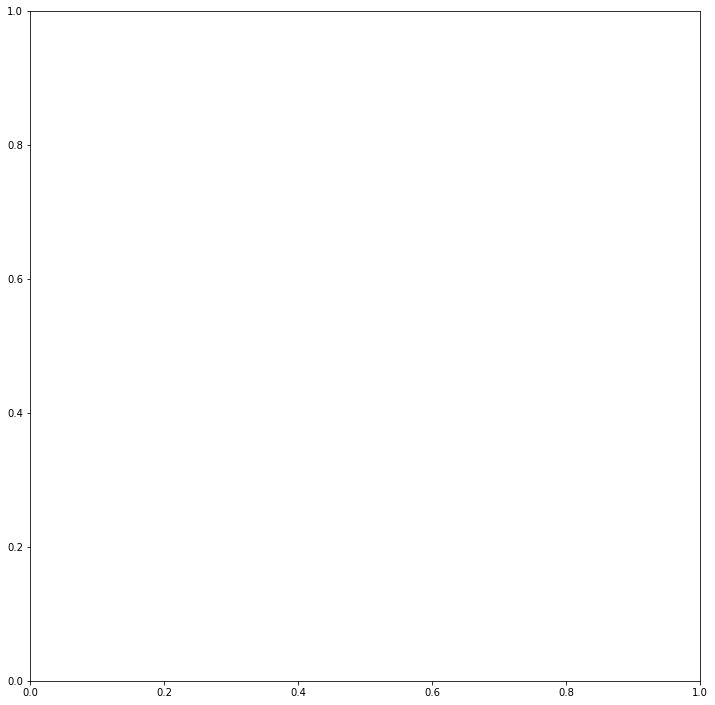

In [18]:
inspect_trn_data()
inspect_val_data()

In [17]:
def is_long_label(label):
    return not(len(np.where(label > 0)[0]) < 10)

In [18]:
def evaluate(base_model, batch_num=None):
    [X_test1, X_test2, X_test3, y_test, _, label_length], _  = val_data()
    if batch_num==None: batch_num = len(X_test1)
    pred = base_model.predict([X_test1[:batch_num], X_test2[:batch_num], X_test3[:batch_num]])
    correct_number = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        
        #-1 是ctc返回的  代表empty
        l = out[j][np.where(out[j] != -1)[0]]
        equal =  label_length[j] == len(l) and np.array_equal(l, y_test[j][:label_length[j][0]])
        if equal:
            correct_number = correct_number+1
    
    return correct_number/batch_num

In [19]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_train_end(self, logs=None):
        acc = evaluate(base_model)
        self.accs.append(acc)
        acc = acc *100
        print(' acc: {}%'.format(acc))
        
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


In [27]:

def conv_layer():
    img_input = Input(shape=(None, 60, 3))
    inner = Convolution2D(64, 3, 3)(img_input)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D()(inner)

    inner = Convolution2D(128, 3, 3)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D()(inner)

    inner = Convolution2D(256, 3, 3)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Convolution2D(256, 3, 3)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D((1,2))(inner)

    inner = Convolution2D(512, 3, 3, border_mode='same')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Convolution2D(512, 3, 3,  border_mode='same')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D((1,2))(inner)

    inner = Convolution2D(512, 2, 2)(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    
    inner = Lambda(map2seq, output_shape=map2seq_output_shape)(inner)
    
    return Model(img_input, inner, name='conv_layer')

def rnn_layer():
    ts_input = Input(shape=(None, 512))
    inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='sum')(ts_input)
    inner = BatchNormalization()(inner)

    inner = Bidirectional(LSTM(256, return_sequences=True, inner_init='identity'), merge_mode='concat')(inner)
    inner = BatchNormalization()(inner)
    
    return Model(ts_input, inner, name='rnn_layer')



In [28]:

conv_base = conv_layer()
rnn_base = rnn_layer()

input_left = Input(name='the_input_left', shape=(120, 60, 3), dtype='float32')
inner = BatchNormalization()(input_left)
left_feature = conv_base(inner) 

input_mid = Input(name='the_input_mid', shape=(120, 60, 3), dtype='float32')
inner = BatchNormalization()(input_mid)
mid_feature = conv_base(inner) 

input_right = Input(name='the_input_right', shape=(400, 60, 3), dtype='float32')
inner = BatchNormalization()(input_right)
right_feature = conv_base(inner) 


inner = merge([left_feature, mid_feature, right_feature], mode='concat', concat_axis=1)

#left_rnn = rnn_base(left_feature)
#mid_rnn = rnn_base(mid_feature)
#right_rnn = rnn_base(right_feature)
#inner = merge([left_rnn, mid_rnn, right_rnn], mode='concat', concat_axis=1)


inner = rnn_base(inner)


y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=[input_left, input_mid, input_right], output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_left, input_mid, input_right, labels, input_length, label_length], loss_out)
    


model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input_left (InputLayer)      (None, 120, 60, 3)    0                                            
____________________________________________________________________________________________________
the_input_mid (InputLayer)       (None, 120, 60, 3)    0                                            
____________________________________________________________________________________________________
the_input_right (InputLayer)     (None, 400, 60, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_22 (BatchNorm (None, 120, 60, 3)    12          the_input_left[0][0]             
___________________________________________________________________________________________

In [39]:
from keras.utils.visualize_util import plot
from IPython.display import Image

plot(model, to_file="model.png", show_shapes=True)
Image('model.png')

ImportError: No module named pydot

In [29]:
#x_trn_len = ((len(img_gen.trn_idxs)//batch_size)/10) * batch_size
#x_val_len = ((len(img_gen.val_idxs)//batch_size)/10) * batch_size * 2
x_trn_len = len(img_gen.trn_idxs)//batch_size * batch_size
x_val_len = len(img_gen.val_idxs)//batch_size* batch_size

# 9-cnn 1-512-rnn full data 400*60 paper 

In [30]:
evaluator = Evaluate()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=2, mode='min')
checkpointer = ModelCheckpoint(filepath='v6/weights.hdf5', verbose=1, save_best_only=True)
history = LossHistory()



In [37]:
p_model = make_parallel(model, 2)

In [31]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')

In [34]:
%mkdir v6
checkpointer = ModelCheckpoint(filepath='v6/weights.hdf5', verbose=1, save_best_only=True)

In [33]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, 
                               callbacks=[evaluator, reduce_lr, checkpointer, history],
                               validation_data=val_data(), nb_val_samples=x_val_len,
                                )

Epoch 1/30
89920/89920 [==============================] - 2046s - loss: 36.0945 - val_loss: 7.2441
Epoch 2/30
89920/89920 [==============================] - 2050s - loss: 2.5484 - val_loss: 1.8186
Epoch 3/30
  192/89920 [..............................] - ETA: 1868s - loss: 1.9324

KeyboardInterrupt: 

In [35]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, 
                               callbacks=[evaluator, reduce_lr, checkpointer, history],
                               validation_data=val_data(), nb_val_samples=x_val_len,
                                )

Epoch 1/30
89920/89920 [==============================] - 2067s - loss: 1.6476 - val_loss: 1.1470
Epoch 2/30
89920/89920 [==============================] - 2062s - loss: 1.3465 - val_loss: 0.7954
Epoch 3/30
89920/89920 [==============================] - 2008s - loss: 1.1520 - val_loss: 0.6427
Epoch 4/30
89920/89920 [==============================] - 2034s - loss: 1.0261 - val_loss: 0.4695
Epoch 5/30
89920/89920 [==============================] - 2031s - loss: 0.9363 - val_loss: 0.5364
Epoch 6/30
89920/89920 [==============================] - 2031s - loss: 0.8679 - val_loss: 0.5082
Epoch 7/30
89920/89920 [==============================] - 2037s - loss: 0.8218 - val_loss: 0.4171
Epoch 8/30
89920/89920 [==============================] - 2044s - loss: 0.7804 - val_loss: 0.5386
Epoch 9/30
89920/89920 [==============================] - 2042s - loss: 0.7474 - val_loss: 0.3526
Epoch 10/30
89920/89920 [==============================] - 2036s - loss: 0.7284 - val_loss: 0.4135
Epoch 11/30
89920/8

KeyboardInterrupt: 

In [ ]:
evaluator.on_train_end()

 acc: 92.5457802548%


In [ ]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, 
                               callbacks=[evaluator, reduce_lr, checkpointer, history],
                                validation_data=val_data(), nb_val_samples=x_val_len,
                                )

Epoch 1/30
89920/89920 [==============================] - 1922s - loss: 44.5158 - val_loss: 6.8205
Epoch 2/30
65344/89920 [====================>.........] - ETA: 535s - loss: 5.6072

KeyboardInterrupt: 

In [ ]:
evaluator.on_train_end()

In [ ]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator, reduce_lr, checkpointer, history],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89920/89920 [==============================] - 1503s - loss: 1.4833 - val_loss: 0.3759
Epoch 2/30
89920/89920 [==============================] - 1982s - loss: 1.4652 - val_loss: 0.3536
Epoch 3/30
89920/89920 [==============================] - 1983s - loss: 1.4700 - val_loss: 0.4435
Epoch 4/30
89920/89920 [==============================] - 1993s - loss: 1.4664 - val_loss: 0.3610
Epoch 5/30
43648/89920 [=============>................] - ETA: 1002s - loss: 1.4579

KeyboardInterrupt: 

In [51]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30, callbacks=[evaluator, reduce_lr, checkpointer, history],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/30
89920/89920 [==============================] - 2045s - loss: 0.6784 - val_loss: 0.2721
Epoch 2/30
89920/89920 [==============================] - 2029s - loss: 0.6598 - val_loss: 0.2724
Epoch 3/30
 1088/89920 [..............................] - ETA: 1665s - loss: 0.6714

KeyboardInterrupt: 

In [26]:
model.save_weights('94.16.wgt')

In [35]:
checkpointer = ModelCheckpoint(filepath='v2/weights.hdf5', verbose=1, save_best_only=True)


In [39]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, cooldown=2, mode='min')

In [37]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,callbacks=[EarlyStopping(patience=10), checkpointer],
                    validation_data=val_data(), nb_val_samples=x_val_len)
evaluator.on_epoch_end(30)

Epoch 1/30
89984/89984 [==============================] - 865s - loss: 0.7738 - val_loss: 0.2646
Epoch 2/30
89984/89984 [==============================] - 862s - loss: 0.7660 - val_loss: 0.2555
Epoch 3/30
89984/89984 [==============================] - 861s - loss: 0.7675 - val_loss: 0.2392
Epoch 4/30
89984/89984 [==============================] - 862s - loss: 0.7610 - val_loss: 0.2278
Epoch 5/30
89984/89984 [==============================] - 864s - loss: 0.7509 - val_loss: 0.2466
Epoch 6/30
89984/89984 [==============================] - 863s - loss: 0.7527 - val_loss: 0.2477
Epoch 7/30
89984/89984 [==============================] - 840s - loss: 0.7467 - val_loss: 0.2383
Epoch 8/30
 9856/89984 [==>...........................] - ETA: 672s - loss: 0.7433

KeyboardInterrupt: 

In [38]:
evaluator.on_epoch_end(30)

 acc: 94.1866292473% long: 0% short: 94.1866292473%


In [ ]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,callbacks=[EarlyStopping(patience=10), checkpointer, reduce_lr],
                    validation_data=val_data(), nb_val_samples=x_val_len)
evaluator.on_epoch_end(30)

Epoch 1/30
89984/89984 [==============================] - 778s - loss: 0.7487 - val_loss: 0.2125
Epoch 2/30
89984/89984 [==============================] - 807s - loss: 0.7405 - val_loss: 0.2076
Epoch 3/30
89984/89984 [==============================] - 890s - loss: 0.7473 - val_loss: 0.2161
Epoch 4/30
89984/89984 [==============================] - 887s - loss: 0.7420 - val_loss: 0.2464
Epoch 5/30
89984/89984 [==============================] - 881s - loss: 0.7436 - val_loss: 0.2291
Epoch 6/30
89984/89984 [==============================] - 862s - loss: 0.7292 - val_loss: 0.2168
Epoch 7/30
89984/89984 [==============================] - 781s - loss: 0.7372 - val_loss: 0.2224
Epoch 8/30
89984/89984 [==============================] - 781s - loss: 0.7392 - val_loss: 0.2100
Epoch 9/30
89984/89984 [==============================] - 825s - loss: 0.6158 - val_loss: 0.1639
Epoch 10/30
89984/89984 [==============================] - 779s - loss: 0.5121 - val_loss: 0.1394
Epoch 18/30
89984/89984 [====

In [43]:
history2 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30,callbacks=[EarlyStopping(patience=10), checkpointer, reduce_lr],
                    validation_data=val_data(), nb_val_samples=x_val_len)
evaluator.on_epoch_end(30)

Epoch 1/30
89984/89984 [==============================] - 877s - loss: 0.4788 - val_loss: 0.1318
Epoch 2/30
89984/89984 [==============================] - 877s - loss: 0.4773 - val_loss: 0.1301
Epoch 3/30
89984/89984 [==============================] - 871s - loss: 0.4687 - val_loss: 0.1303
Epoch 4/30
89984/89984 [==============================] - 880s - loss: 0.4666 - val_loss: 0.1300
Epoch 5/30
89984/89984 [==============================] - 878s - loss: 0.4769 - val_loss: 0.1295
Epoch 6/30
89984/89984 [==============================] - 874s - loss: 0.4777 - val_loss: 0.1298
Epoch 7/30
89984/89984 [==============================] - 879s - loss: 0.4700 - val_loss: 0.1298
Epoch 8/30
89984/89984 [==============================] - 875s - loss: 0.4692 - val_loss: 0.1296
Epoch 9/30
89984/89984 [==============================] - 877s - loss: 0.4724 - val_loss: 0.1294
Epoch 10/30
89984/89984 [==============================] - 878s - loss: 0.4775 - val_loss: 0.1302
Epoch 11/30
89984/89984 [====

In [44]:
history2.history

{'loss': [0.47881941097771291,
  0.47733066914600464,
  0.46873428511458476,
  0.46655659818727718,
  0.47688581182450523,
  0.47768510806017883,
  0.46999965576855079,
  0.46920735073960779,
  0.47240240493548202,
  0.47745041576231356,
  0.46924679491610649,
  0.46692189306635434,
  0.46436610388679489,
  0.46984775564706172,
  0.46945625805371516,
  0.46332385501483853,
  0.4682869573957042,
  0.47705970005069992,
  0.46316691144113858,
  0.45992542615168297,
  0.46575617375565032,
  0.47223377855465476,
  0.46675152511231249,
  0.46692577441081212,
  0.46909082942187869,
  0.471380668251138,
  0.4679029435714227,
  0.4657828657600398,
  0.46575249609130714,
  0.46745961757739779],
 'lr': [1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-05,
  1.0000001e-06,
  1.0000001e-06,
  1.0000001e-06,
  1.0000001e-06,
  1.0000001e-06,
  1.0000001e-06,
  1.0000001

# 9-cnn-64-512 + 1-512-rnn


In [30]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)

Epoch 1/15
9024/8992 [==============================] - 107s - loss: 99.3167   
Epoch 2/15
9024/8992 [==============================] - 104s - loss: 61.1107   
Epoch 3/15
9024/8992 [==============================] - 91s - loss: 33.2440    
Epoch 4/15
9024/8992 [==============================] - 100s - loss: 19.1650   
Epoch 5/15
9024/8992 [==============================] - 104s - loss: 13.3167   
Epoch 6/15
9024/8992 [==============================] - 104s - loss: 10.6179   
Epoch 7/15
9024/8992 [==============================] - 104s - loss: 8.7041   
Epoch 8/15
9024/8992 [==============================] - 104s - loss: 7.6173   
Epoch 9/15
9024/8992 [==============================] - 105s - loss: 6.7920   
Epoch 10/15
9024/8992 [==============================] - 104s - loss: 6.2848   
Epoch 11/15
9024/8992 [==============================] - 104s - loss: 5.7416   
Epoch 12/15
9024/8992 [==============================] - 104s - loss: 5.5035   
Epoch 13/15
9024/8992 [====================

In [32]:
vx, vy = val_data()


10050/10050 [==============================] - 28s    
2.69755276039


In [33]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8992 [==============================] - 96s - loss: 4.3617    
Epoch 2/15
9024/8992 [==============================] - 105s - loss: 4.2062   
Epoch 3/15
9024/8992 [==============================] - 104s - loss: 4.1070   
Epoch 4/15
9024/8992 [==============================] - 105s - loss: 3.8300   
Epoch 5/15
9024/8992 [==============================] - 105s - loss: 3.8514   
Epoch 6/15
9024/8992 [==============================] - 104s - loss: 3.7601   
Epoch 7/15
9024/8992 [==============================] - 104s - loss: 3.6524   
Epoch 8/15
9024/8992 [==============================] - 104s - loss: 3.4756   
Epoch 9/15
9024/8992 [==============================] - 104s - loss: 3.4506   
Epoch 10/15
9024/8992 [==============================] - 105s - loss: 3.3230   
Epoch 11/15
9024/8992 [==============================] - 103s - loss: 3.2562   
Epoch 12/15
9024/8992 [==============================] - 104s - loss: 3.2516   
Epoch 13/15
9024/8992 [==========================

In [34]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8992 [==============================] - 87s - loss: 2.9196    
Epoch 2/15
9024/8992 [==============================] - 85s - loss: 2.8707    
Epoch 3/15
9024/8992 [==============================] - 86s - loss: 2.9501    
Epoch 4/15
9024/8992 [==============================] - 91s - loss: 2.8118    
Epoch 5/15
9024/8992 [==============================] - 103s - loss: 2.8828   
Epoch 6/15
9024/8992 [==============================] - 103s - loss: 2.7026   
Epoch 7/15
9024/8992 [==============================] - 103s - loss: 2.7355   
Epoch 8/15
9024/8992 [==============================] - 103s - loss: 2.7039   
Epoch 9/15
9024/8992 [==============================] - 101s - loss: 2.5210   
Epoch 10/15
9024/8992 [==============================] - 102s - loss: 2.5388   
Epoch 11/15
9024/8992 [==============================] - 101s - loss: 2.6025   
Epoch 12/15
9024/8992 [==============================] - 102s - loss: 2.5981   
Epoch 13/15
9024/8992 [==========================

In [35]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)

Epoch 1/15
9024/8992 [==============================] - 87s - loss: 2.3386    
Epoch 2/15
9024/8992 [==============================] - 102s - loss: 2.3883   
Epoch 3/15
9024/8992 [==============================] - 103s - loss: 2.4335   
Epoch 4/15
9024/8992 [==============================] - 102s - loss: 2.2574   
Epoch 5/15
9024/8992 [==============================] - 102s - loss: 2.4010   
Epoch 6/15
9024/8992 [==============================] - 103s - loss: 2.3340   
Epoch 7/15
9024/8992 [==============================] - 102s - loss: 2.3046   
Epoch 8/15
9024/8992 [==============================] - 101s - loss: 2.3595   
Epoch 9/15
9024/8992 [==============================] - 102s - loss: 2.2396   
Epoch 10/15
9024/8992 [==============================] - 102s - loss: 2.2418   
Epoch 11/15
9024/8992 [==============================] - 102s - loss: 2.2625   
Epoch 12/15
9024/8992 [==============================] - 102s - loss: 2.1715   
Epoch 13/15
9024/8992 [==========================

#  9-cnn-64-512    2-256-rnn

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30)



Epoch 1/30
9024/8992 [==============================] - 127s - loss: 99.9664    
Epoch 2/30
9024/8992 [==============================] - 128s - loss: 59.6732   
Epoch 3/30
9024/8992 [==============================] - 128s - loss: 35.7162   
Epoch 4/30
9024/8992 [==============================] - 152s - loss: 21.3635   
Epoch 5/30
9024/8992 [==============================] - 152s - loss: 14.8342   
Epoch 6/30
9024/8992 [==============================] - 152s - loss: 11.5182   
Epoch 7/30
9024/8992 [==============================] - 152s - loss: 9.4364   
Epoch 8/30
9024/8992 [==============================] - 152s - loss: 8.3076   
Epoch 9/30
9024/8992 [==============================] - 151s - loss: 7.2707   
Epoch 10/30
9024/8992 [==============================] - 151s - loss: 6.6296   
Epoch 11/30
9024/8992 [==============================] - 137s - loss: 5.9807   
Epoch 12/30
9024/8992 [==============================] - 125s - loss: 5.5614   
Epoch 13/30
9024/8992 [===================

NameError: name 'xy' is not defined

In [39]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

10050/10050 [==============================] - 46s    
1.35222773166
 acc: 68.447761194% long: 0% short: 68.447761194%


# 9-cnn-64-512 1-512-rnn    no-data-augamentation

In [42]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 107s - loss: 76.5256   
Epoch 2/15
9024/8992 [==============================] - 104s - loss: 30.1881   
Epoch 3/15
9024/8992 [==============================] - 104s - loss: 20.0389   
Epoch 4/15
9024/8992 [==============================] - 104s - loss: 16.0240   
Epoch 5/15
9024/8992 [==============================] - 104s - loss: 13.0939   
Epoch 6/15
9024/8992 [==============================] - 103s - loss: 9.7932   
Epoch 7/15
9024/8992 [==============================] - 104s - loss: 7.1038   
Epoch 8/15
9024/8992 [==============================] - 103s - loss: 5.3637   
Epoch 9/15
9024/8992 [==============================] - 103s - loss: 4.0550   
Epoch 10/15
9024/8992 [==============================] - 104s - loss: 3.3188   
Epoch 11/15
9024/8992 [==============================] - 98s - loss: 2.9263    
Epoch 12/15
9024/8992 [==============================] - 102s - loss: 2.7580   
Epoch 13/15
9024/8992 [=====================

# 9-cnn-64-512 1-512-rnn  no-data-augamentation  dropout 0.2

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 108s - loss: 82.1191   
Epoch 2/15
9024/8992 [==============================] - 93s - loss: 31.4453    
Epoch 3/15
9024/8992 [==============================] - 86s - loss: 20.4815    
Epoch 4/15
9024/8992 [==============================] - 86s - loss: 16.7978    
Epoch 5/15
9024/8992 [==============================] - 86s - loss: 14.2901    
Epoch 6/15
6784/8992 [=====================>........] - ETA: 21s - loss: 11.9260

In [47]:
history1.history

{'loss': [82.119107672508733,
  31.44530929403102,
  20.481513084249293,
  16.79782994588216,
  14.290107030395076,
  11.504723589471046,
  8.7697446227919134,
  6.4063071934043938,
  5.1893428893799474,
  3.971756120100089,
  3.2877366001724351,
  3.044551298973408,
  2.7796175530616272,
  2.4218144788809703,
  2.5285970623611558]}

In [48]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

10048/10050 [============================>.] - ETA: 0s2.43480613743
 acc: 52.7462686567% long: 0% short: 52.7462686567%


In [49]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/30
9024/8992 [==============================] - 105s - loss: 2.0761   
Epoch 2/30
9024/8992 [==============================] - 104s - loss: 2.0007   
Epoch 3/30
9024/8992 [==============================] - 104s - loss: 1.8460   
Epoch 4/30
9024/8992 [==============================] - 104s - loss: 1.7150   
Epoch 5/30
9024/8992 [==============================] - 105s - loss: 1.7219   
Epoch 6/30
9024/8992 [==============================] - 104s - loss: 1.7782   
Epoch 7/30
9024/8992 [==============================] - 105s - loss: 1.6543   
Epoch 8/30
9024/8992 [==============================] - 105s - loss: 1.6461   
Epoch 9/30
9024/8992 [==============================] - 104s - loss: 1.5105   
Epoch 10/30
9024/8992 [==============================] - 104s - loss: 1.4885   
Epoch 11/30
9024/8992 [==============================] - 94s - loss: 1.3563    
Epoch 12/30
9024/8992 [==============================] - 86s - loss: 1.3986    
Epoch 13/30
9024/8992 [==========================

KeyboardInterrupt: 

In [50]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

10048/10050 [============================>.] - ETA: 0s1.55165211453
 acc: 68.6268656716% long: 0% short: 68.6268656716%


# 9-cnn-64-512 1-512-rnn  no-data-augamentation  dropout 0.5

In [53]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 108s - loss: 83.2673   
Epoch 2/15
9024/8992 [==============================] - 105s - loss: 37.8248   
Epoch 3/15
9024/8992 [==============================] - 106s - loss: 22.3476   
Epoch 4/15
9024/8992 [==============================] - 105s - loss: 18.5904   
Epoch 5/15
9024/8992 [==============================] - 105s - loss: 16.1836   
Epoch 6/15
9024/8992 [==============================] - 104s - loss: 13.8324   
Epoch 7/15
9024/8992 [==============================] - 104s - loss: 11.4701   
Epoch 8/15
9024/8992 [==============================] - 86s - loss: 9.3513    
Epoch 9/15
9024/8992 [==============================] - 86s - loss: 7.4384    
Epoch 10/15
9024/8992 [==============================] - 86s - loss: 6.4672    
Epoch 11/15
9024/8992 [==============================] - 86s - loss: 5.1457    
Epoch 12/15
9024/8992 [==============================] - 86s - loss: 4.6310    
Epoch 13/15
9024/8992 [===================

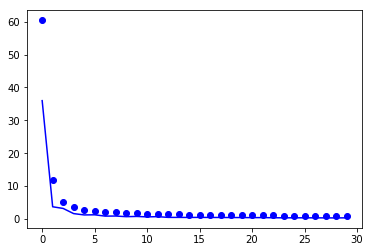

In [66]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

plt.show()


In [ ]:
model.optimizer.lr=0.00001
history3 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.5804[ 0 39  5 13 13  7 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0 14 10 13 15  8  2  0  0 10  8 14  9 14  4 39  5 11  9  6  8  6  1  1  4  1 14  9 10 10  1]
 acc: 69.959228%
 short: 91.786268%
 l: 33.765363%
215552/215552 [==============================] - 824s - loss: 2.5802 - val_loss: 1.9581
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 3.6731[ 0 19  5 13 13  7 12 15  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0  9 11 10 13  8  2  7 15 14  7 15  1  4  0  9 13 14 14 13  1  2 25  5 13  7 10  6 13 15  1]
[ 0  9  7  7 12  6  6  3  0 27  5 13  7  6  6 12  2 11  6  7 14  6  1  1  4 12 10  7 13  8  1]
 acc: 71.535455%
 short: 90.802507%
 l: 39.586592%
215552/215552 [==============================] - 825s - loss: 3.6725 - val_loss: 1.6757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.2219 

KeyboardInterrupt: 

In [26]:
def show_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        print(img_gen.to_pretty_label(l))
        plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

In [45]:
def show_wrong_result(base_model, batch_num=None):
    [X_test1, X_test2, X_test3, y_test, _, label_length], _  = val_data()
    if batch_num==None: batch_num = len(X_test1)
    pred = base_model.predict([X_test1[:batch_num], X_test2[:batch_num], X_test3[:batch_num]])
    correct_number=0
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        
        #-1 是ctc返回的  代表empty
        l = out[j][np.where(out[j] != -1)[0]]
        equal =  label_length[j] == len(l) and np.array_equal(l, y_test[j][:label_length[j][0]])
        if equal:
            correct_number = correct_number+1
            #plt.figure(figsize=(10,60), frameon=True)
            #plt.imshow(X_test[j].transpose(1,0,2).reshape(60,400,3))
            #plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
        else:
            print(u'{}  {}'.format(img_gen.to_pretty_label(l), img_gen.to_pretty_label(y_test[j])))
    print(correct_number/batch_num)
            
     

In [47]:
show_wrong_result(base_model, 200)

到=2326;烧=18166;(烧*(51966-64096))-到/62591  到=2326;烧=18466;(烧*(51966-64096))-到/62591
到=57680;塘=42045;(锁+16513)*到/23590-29718  到=57680;锁=42045;(锁+16513)*到/23590-29718
海=3135;铁=79496;(铁-(海/32672+2712))+3188  海=31365;铁=79496;(铁-(海/32672+2712))+3188
回=45424;烧=55602;(烧-(回/58910*92100))+39732  回=45424;烧=55602;(烧-(回/68910*92100))+39732
河=18641;68030*(37036-73271*河/834)  河=18641;68030*(37036-73271*河/534)
不=47465;柳=78477;(不/3365-51096)*(柳-54210)  不=47465;柳=78477;(不/3355-51096)*(柳-54210)
君=54716;烧=75833;烧-1863*(君/73959-83889)  君=54716;烧=75833;烧-1863*(君/73956-83889)
复=51023;锁=79030;复/76421+(9228+(324-锁))  复=51023;锁=79030;复/75421+(9228+(324-锁))
不=4507;柳=32973;不/40338+(柳-31791)-59697  不=4507;柳=32973;不/30338+(柳-31791)-59697
复=68714;13856-复/3002*99751+67744  复=68714;13856-复/3062*99751+67744
天=60146;圳=86959;(40604-(91575*天/14503))*圳  天=60146;圳=80959;(40604-(91575*天/14503))*圳
黄=41985;塘=84040;(黄/62341-54391)-(91356+塘)  黄=41986;塘=84040;(黄/62341-54391)-(91356+塘)
0.94


In [61]:
model.save_weights('l2_first_54.wgt')

In [92]:
model.load_weights('l2_first_54.wgt')

In [95]:
model.save('l2_first_54.h5')

In [59]:
model.save_weights('xxx.wgt')

In [22]:
model.load_weights('xxx.wgt')

In [ ]:
model